In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/starbucks-capstone-challenge/transcript.csv
/kaggle/input/starbucks-capstone-challenge/profile.csv
/kaggle/input/starbucks-capstone-challenge/portfolio.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
transcript = pd.read_csv('/kaggle/input/starbucks-capstone-challenge/transcript.csv')
portfolio = pd.read_csv('/kaggle/input/starbucks-capstone-challenge/profile.csv')
profile = pd.read_csv('/kaggle/input/starbucks-capstone-challenge/portfolio.csv')

Offers received 25300
Offers viewed   13581 (53.7% of received)
Offers completed 4176 (16.5% of received)


/tmp/ipykernel_17/2892966715.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=events_to_plot, y=counts, palette="viridis")


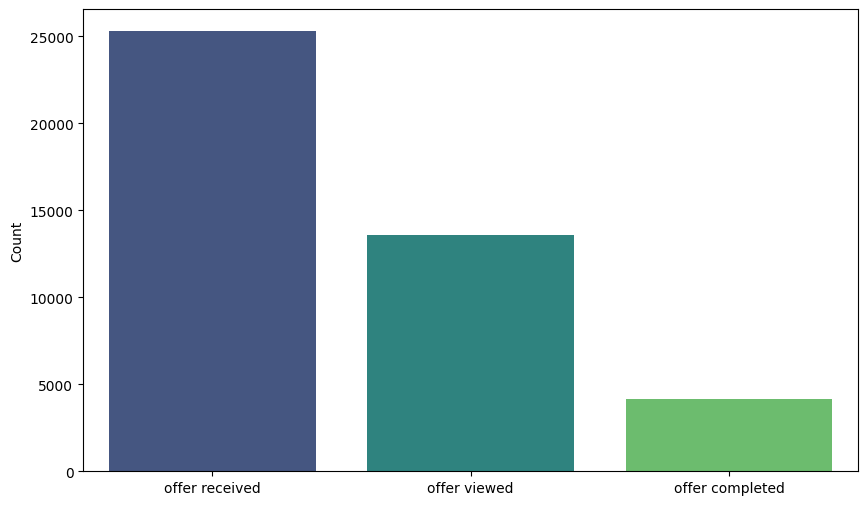

In [4]:
event_counts = transcript['event'].value_counts()
total_events = len(transcript)

n_received = event_counts.get('offer received', 0)
n_viewed = event_counts.get('offer viewed', 0)
n_completed = event_counts.get('offer completed', 0)

print(f"Offers received {n_received}")
print(f"Offers viewed   {n_viewed} ({n_viewed/n_received*100:.1f}% of received)")
print(f"Offers completed {n_completed} ({n_completed/n_received*100:.1f}% of received)")

#Visualization
events_to_plot = ['offer received', 'offer viewed', 'offer completed']
counts = [n_received, n_viewed, n_completed]

plt.figure(figsize=(10, 6))
sns.barplot(x=events_to_plot, y=counts, palette="viridis")
plt.ylabel("Count")
plt.show()

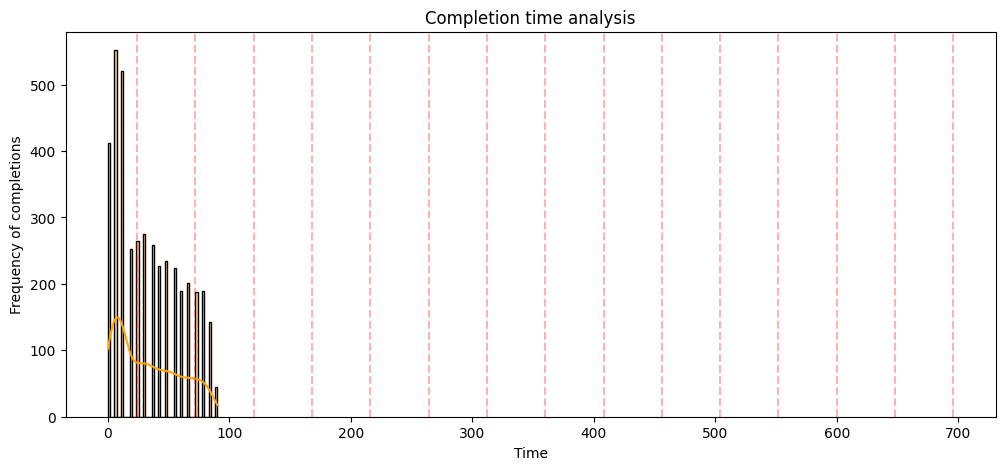

In [5]:
completed_data = transcript[transcript['event'] == 'offer completed']

plt.figure(figsize=(12, 5))
sns.histplot(completed_data['time'], bins=50, kde=True, color='orange')
plt.title("Completion time analysis")
plt.xlabel("Time")
plt.ylabel("Frequency of completions")

for day in range(1, 30, 2):
    plt.axvline(day * 24, color='red', linestyle='--', alpha=0.3)

plt.show()